In [141]:
from utils.config_MCMC import*
from utils.core import *

# Run one sim
from classes.european_commission import *
EC = EuropeanCommission('../data/', reload = False)

EC.meetings['TR ID'] = EC.meetings['TR ID'].apply(lambda x: tuple(sorted(list(set(x)))))
EC.meetings['EC member'] = EC.meetings['EC member'].apply(lambda x: tuple(sorted(list(set(x)))))

multiedges = False

if multiedges:
    edges_df = EC.meetings.copy()
else:
    edges_df = EC.meetings.drop_duplicates(subset = ['TR ID', 'EC member'])


cleanup_kwargs = {    
    'isolates' : False,
    'singletons': False,
    'multiedges': multiedges,
    'connected': False, # To test
    'relabel': False,
    'in_place': True}

# Empirical Hypergraph
edges_emp = edges_df.apply(lambda x: x['TR ID'] + x['EC member'], axis = 1)
H = xgi.Hypergraph(list(edges_emp))
H.cleanup(**cleanup_kwargs)
edges_emp = H.edges.members()

# Empirical subdim
H_orga = xgi.Hypergraph(list(edges_df.apply(lambda x: x['TR ID'], axis = 1))) # Ignore duplicated nodes 
H_ec = xgi.Hypergraph(list(edges_df.apply(lambda x: x['EC member'], axis = 1)))
edges_emp_subdim  = [list( [list(H_orga.edges.members(e)), list(H_ec.edges.members(e))]) for e in H_ec.edges ]

# Empirical orga
H_orga.cleanup(**cleanup_kwargs)
edges_emp_orga = H_orga.edges.members()# remove singleton edges

 
n_steps = 10_00
# Configuration Model
kwargs= {
    'edges' : edges_emp,
    'n_steps' : n_steps,
    'multiedges': multiedges,
    'burnin_steps':2*n_steps,
    'n_clash': 0
    }

edges_conf =  vertex_labeled_MH(**kwargs)
H_conf = xgi.Hypergraph(edges_conf)
assert H_conf.degree() == H.degree()
assert sorted(list(H_conf.size().values())) == sorted(list(H.size().values())) 

# Configuration Model subdim
kwargs= {
    'edges' : edges_emp_subdim,
    'n_steps' : n_steps,
    'multiedges': multiedges,
    'burnin_steps':2*n_steps,
    'n_clash': 0
    }

edges_conf_subdim =  vertex_labeled_MH_subdim(**kwargs)
edges_conf_subdim = [ np.concatenate([list(e1),list(e2)]) for e1, e2 in edges_conf_subdim]
H_conf_sub = xgi.Hypergraph(edges_conf_subdim)

assert H_conf_sub.degree() == H.degree()
assert sorted(list(H_conf.size().values())) == sorted(list(H.size().values()))

# Configuration Model orga_H
kwargs= {
    'edges' : edges_emp_orga,
    'n_steps' : n_steps,
    'multiedges': multiedges,
    'burnin_steps':2*n_steps,
    'n_clash': 0
    }

edges_conf_orga =  vertex_labeled_MH(**kwargs)
H_conf_orga = xgi.Hypergraph(edges_conf_orga)

assert H_conf_orga.degree() == H_orga.degree()
assert sorted(list(H_conf_orga.size().values())) == sorted(list(xgi.Hypergraph(edges_emp_orga).size().values()))



100%|██████████| 3000/3000 [00:03<00:00, 927.28it/s] 


3000 epochs completed, 1000 steps taken, 550 steps rejected.


100%|██████████| 3000/3000 [00:03<00:00, 899.15it/s] 


3000 epochs completed, 1000 steps taken, 584 steps rejected.


100%|██████████| 3000/3000 [00:01<00:00, 2719.22it/s]

3000 epochs completed, 1000 steps taken, 220 steps rejected.


18561 18561
5784 5784


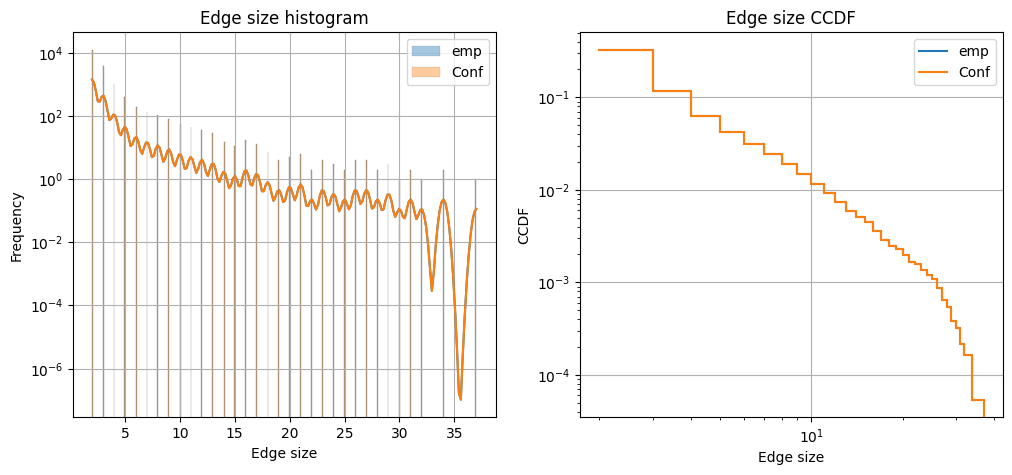

In [52]:
# # Print edge and node counts
H_conf = H_conf_sub.copy()
print(H.num_edges, H_conf.num_edges)
print(H.num_nodes, H_conf.num_nodes)

def plot_histogram(ax, data, label):
    ax.hist(data, alpha=0.5, label=label, bins=30)

def plot_kde(ax, data, label):
    sns.histplot(data, ax=ax, label=label, kde=True,  alpha=0.4)


def plot_ccdf(ax, data, label):
    values, counts = np.unique(data, return_counts=True)
    ccdf = 1 - np.cumsum(counts) / sum(counts)
    ax.plot(values, ccdf, drawstyle='steps-post', label=label)

# Prepare data
data_sets = [
    (H.size().values(), "emp"),
    (H_conf.size().values(), "Conf"),
]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms
for data, label in data_sets:
    plot_kde(ax1, list(data), label)

ax1.set_title("Edge size histogram")
ax1.set_xlabel("Edge size")
ax1.set_ylabel("Frequency")
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plot CCDFs
for data, label in data_sets:
    plot_ccdf(ax2, list(data), label)

ax2.set_title("Edge size CCDF")
ax2.set_xlabel("Edge size")
ax2.set_ylabel("CCDF")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.legend()
ax2.grid(True)

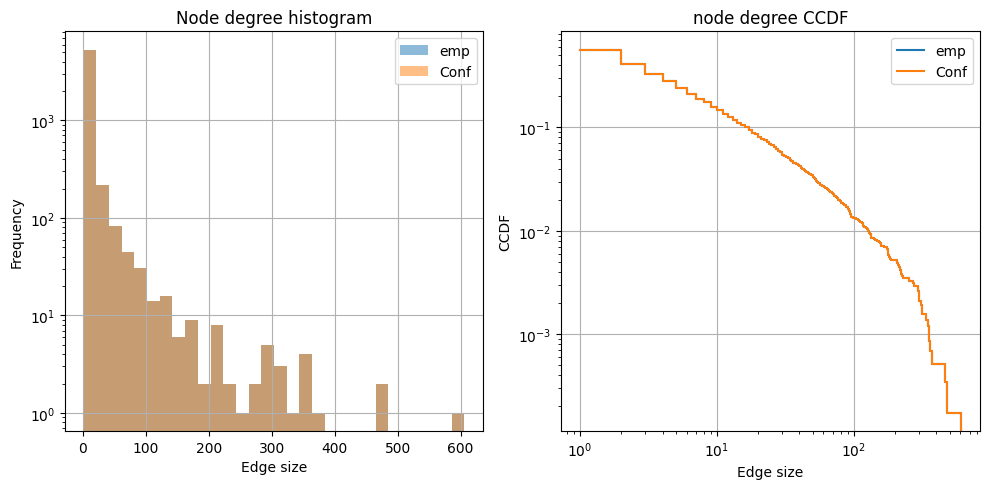

In [53]:
# Prepare data

data_sets = [
    (H.degree().values(), "emp"),
    (H_conf.degree().values(), "Conf"),
]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))

# Plot histograms
for data, label in data_sets:
    plot_histogram(ax1, list(data), label)

ax1.set_title("Node degree histogram")
ax1.set_xlabel("Edge size")
ax1.set_ylabel("Frequency")
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True)

# Plot CCDFs
for data, label in data_sets:
    plot_ccdf(ax2, list(data), label)

ax2.set_title("node degree CCDF")
ax2.set_xlabel("Edge size")
ax2.set_ylabel("CCDF")
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.legend()
ax2.grid(True)
plt.tight_layout()

In [ ]:
orga_df = EC.entities[EC.entities['Type'] == 'Organization']
edges_df = pd.DataFrame({'edges': edges_emp})
mapper = dict(zip(orga_df.index, orga_df['TR Name']))
edges_df['edges_label'] = edges_df['edges'].apply(lambda x:replace_element_in_tuple(x,mapper))
edges_df['min degree'] = edges_df['edges'].apply(lambda x: min(H.degree(node) for node in x))
edges_df['size'] = edges_df['edges'].apply(len)
edges_emp_sorted = edges_df.sort_values('min degree', ascending= False).copy()

In [153]:
orga_df = EC.entities[EC.entities['Type'] == 'Organization']
edges_df = pd.DataFrame({'edges': H_conf_sub.edges.members()})
mapper = dict(zip(orga_df.index, orga_df['TR Name']))
edges_df['edges_label'] = edges_df['edges'].apply(lambda x:replace_element_in_tuple(x,mapper))
edges_df['min degree'] = edges_df['edges'].apply(lambda x: min(H.degree(node) for node in x))
edges_df['size'] = edges_df['edges'].apply(len)
edges_df.sort_values('min degree', ascending= False)
edges_rand_sorted = edges_df.sort_values('min degree', ascending= False).copy()

In [151]:
start = 0
edges_emp_sorted[edges_emp_sorted['size'] >2].iloc[start: start +50]

,edges,edges_label,min degree,size
1596,"{9505781573-45, 06698681039-26, 06798511314-27}","(Bureau Européen des Unions de Consommateurs, ...",83,3
239,"{55820581197-35, 3978240953-79, 06698681039-26}","(SMEunited aisbl, BUSINESSEUROPE, EUROPEAN TRA...",74,3
1655,"{1414929419-24, 96645517357-19, 1083162721-43,...","(WWF European Policy Programme, ClientEarth AI...",63,4
1742,"{1414929419-24, 55888811123-49, 58744833263-19...","(WWF European Policy Programme, Climate Action...",63,5
1557,"{1414929419-24, 58744833263-19, 1083162721-43,...","(WWF European Policy Programme, Transport and ...",63,4
1588,"{1414929419-24, 1083162721-43, 06798511314-27}","(WWF European Policy Programme, Stichting Bird...",63,3
1592,"{1414929419-24, 9832909575-41, 1083162721-43, ...","(WWF European Policy Programme, Greenpeace Eur...",51,4
442,"{96645517357-19, 9832909575-41, 1083162721-43,...","(ClientEarth AISBL, Greenpeace European Unit, ...",51,4
1582,"{9832909575-41, 1083162721-43, 06798511314-27}","(Greenpeace European Unit, Stichting BirdLife ...",51,3
1584,"{55820581197-35, 59513031434-92, 3978240953-79...","(SMEunited aisbl, SGI Europe, BUSINESSEUROPE, ...",44,4


In [152]:

edges_rand_sorted[edges_rand_sorted['size']>2].iloc[start: start +50]

,edges,edges_label,min degree,size
14448,"{Aleksandra Tomczak, Werner Stengg, Lukas Visek}","(Aleksandra Tomczak, Werner Stengg, Lukas Visek)",200,3
14820,"{Christoph Nerlich, Anouk Faber, Nicolas Schmit}","(Christoph Nerlich, Anouk Faber, Nicolas Schmit)",192,3
13139,"{Thierry Breton, Christoph Nerlich, Joan Canto...","(Thierry Breton, Christoph Nerlich, Joan Canto...",192,4
11062,"{Kadri Simson, Stefano Grassi, Katherine Power}","(Kadri Simson, Stefano Grassi, Katherine Power)",186,3
12368,"{Mairead McGuinness, Lucrezia Busa, Florian De...","(Mairead McGuinness, Lucrezia Busa, Florian De...",177,3
12239,"{Lucrezia Busa, Filomena Chirico, Thierry Breton}","(Lucrezia Busa, Filomena Chirico, Thierry Breton)",173,3
10596,"{Christoph Nerlich, Filomena Chirico, Anouk Fa...","(Christoph Nerlich, Filomena Chirico, Anouk Fa...",173,3
12018,"{Filomena Chirico, Janusz Wojciechowski, Kathe...","(Filomena Chirico, Janusz Wojciechowski, Kathe...",154,3
11998,"{Christoph Nerlich, Janusz Wojciechowski, Anou...","(Christoph Nerlich, Janusz Wojciechowski, Anou...",154,3
14212,"{Daniel Braun, Janusz Wojciechowski, Stefano G...","(Daniel Braun, Janusz Wojciechowski, Stefano G...",148,3
